# Visualisations

Ici on génère les graphiques qui seront utilisés dans le rapport, ou qui nous ont été utile pour comprendre et explorer les données

In [29]:
import pandas as pd
import os

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

input_dir = "../data_clean/"
visuals_dir = "../visuals/"

In [30]:
assert os.path.exists(input_dir), f"Il faut exéctuer le script de récolte et nettoyage (clean_data.ipynb) avant de lancer ce notebook ({input_dir} n'existe pas)."

try:
    df_person = pd.read_pickle(os.path.join(input_dir, 'df_person.pkl'))
    df_bio = pd.read_pickle(os.path.join(input_dir, 'df_bio.pkl'))
    df_note = pd.read_pickle(os.path.join(input_dir, 'df_note.pkl'))
    df_visit = pd.read_pickle(os.path.join(input_dir, 'df_visit.pkl'))
    df_condition = pd.read_pickle(os.path.join(input_dir, 'df_condition.pkl'))
    df_facteur_risque = pd.read_pickle(os.path.join(input_dir, 'df_facteur_risque.pkl'))
except FileNotFoundError as e:
    raise FileNotFoundError(f"Il faut exéctuer le script de récolte et nettoyage (clean_data.ipynb) avant de lancer ce notebook ({e.filename} n'existe pas).")

In [31]:
def a_le_cancer_sein(person_id, df_condition):
    cancer_sein_codes = {"C50", "C500", "C501", "C502", "C503", "C504"}
    patient_conditions = df_condition[df_condition['person_id'] == person_id]
    return any(str(code) in cancer_sein_codes for code in patient_conditions['condition_source_value'])

def na_pas_le_cancer_sein(person_id, df_condition):
    cancer_sein_codes = {"C50", "C500", "C501", "C502", "C503", "C504"}
    patient_conditions = df_condition[df_condition['person_id'] == person_id]
    return not any(str(code) in cancer_sein_codes for code in patient_conditions['condition_source_value'])

/var/folders/kg/hgy_q5m96xgcws72gzltdk3r0000gn/T/ipykernel_55938/14247411.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


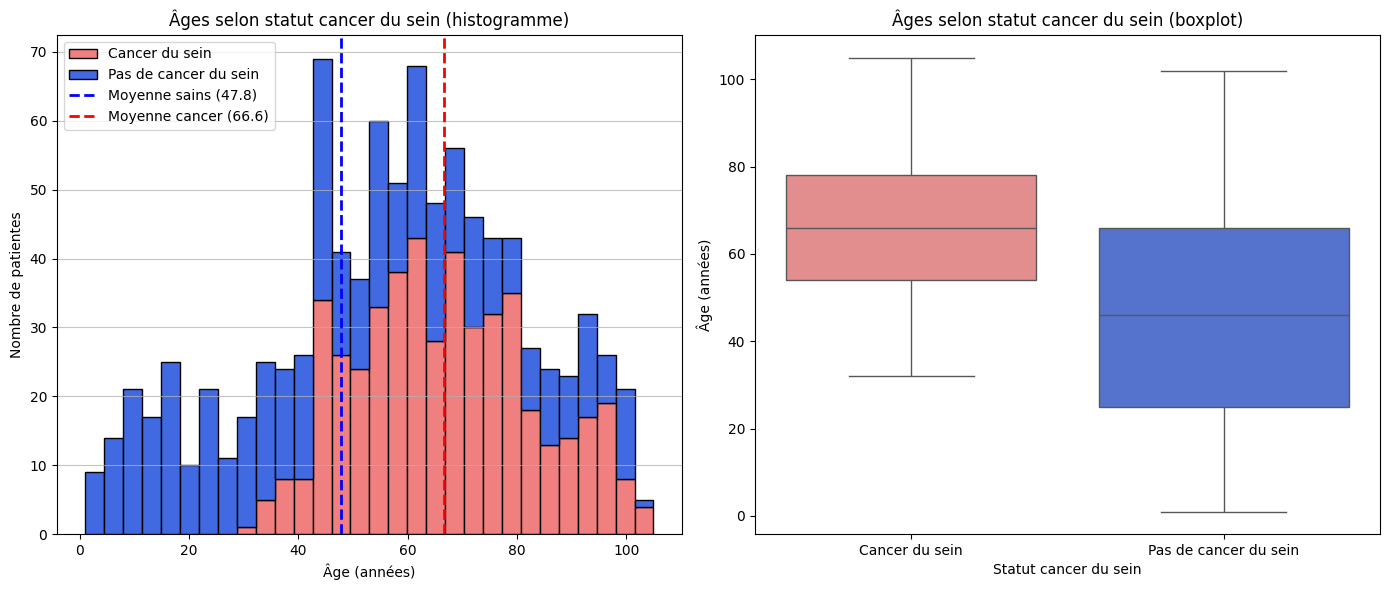

In [32]:
current_year = datetime.now().year
df_person = df_person.copy()
df_person = df_person[df_person['birth_datetime'].notna()]
df_person['age'] = current_year - df_person['birth_datetime'].dt.year

df_person['cancer_sein'] = df_person['person_id'].apply(lambda pid: a_le_cancer_sein(pid, df_condition))
df_person['pas_cancer_sein'] = df_person['person_id'].apply(lambda pid: na_pas_le_cancer_sein(pid, df_condition))

age_cancer = df_person[df_person['cancer_sein'] == True]['age']
age_pas_cancer = df_person[df_person['cancer_sein'] == False]['age']

moyenne_age_globale = df_person['age'].mean()
moyenne_sains = age_pas_cancer.mean()
moyenne_age_cancer = age_cancer.mean()

# Création d’une figure avec deux subplots côte à côte
fig, (ax_histo, ax_box) = plt.subplots(1, 2, figsize=(14, 6))

# --- 1) Histogramme sur le subplot de gauche (ax_histo) ---
ax_histo.hist(
    [age_cancer, age_pas_cancer],
    bins=30,
    stacked=True,
    color=['lightcoral', 'royalblue'],
    label=['Cancer du sein', 'Pas de cancer du sein'],
    edgecolor='black',
)
ax_histo.axvline(moyenne_sains, color='blue', linestyle='dashed', linewidth=2,
                  label=f'Moyenne sains ({moyenne_sains:.1f})')
ax_histo.axvline(moyenne_age_cancer, color='red', linestyle='dashed', linewidth=2,
                  label=f'Moyenne cancer ({moyenne_age_cancer:.1f})')

ax_histo.set_xlabel('Âge (années)')
ax_histo.set_ylabel('Nombre de patientes')
ax_histo.set_title("Âges selon statut cancer du sein (histogramme)")
ax_histo.legend(loc='upper left')
ax_histo.grid(axis='y', alpha=0.75)

# --- 2) Boxplot sur le subplot de droite (ax_box) ---
sns.boxplot(
    x=df_person['cancer_sein'].map({True: 'Cancer du sein', False: 'Pas de cancer du sein'}),
    y=df_person['age'],
    palette={'Cancer du sein': 'lightcoral', 'Pas de cancer du sein': 'royalblue'},
    ax=ax_box
)
ax_box.set_xlabel('Statut cancer du sein')
ax_box.set_ylabel('Âge (années)')
ax_box.set_title("Âges selon statut cancer du sein (boxplot)")

# Ajustements finaux
plt.tight_layout()
plt.savefig(os.path.join(visuals_dir, 'comparaison_age_cancer_sein.png'), dpi=300)
plt.show()

/var/folders/kg/hgy_q5m96xgcws72gzltdk3r0000gn/T/ipykernel_55938/1782763109.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


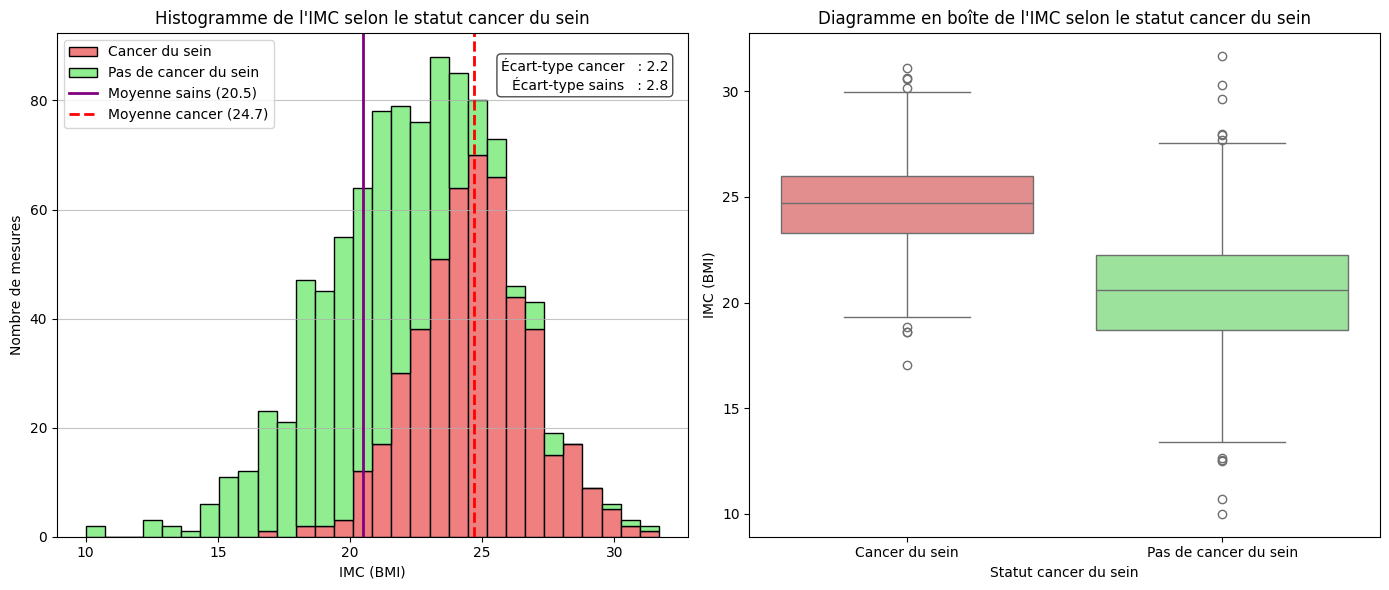

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# — Étapes préalables (inchangées) —
# 1. Lier chaque mesure d'IMC à une personne
bmi_bio = df_bio[df_bio['concept_source_value'] == 'bmi'][['visit_occurrence_id', 'transformed_value']].dropna()
bmi_bio = bmi_bio.merge(df_visit[['visit_occurrence_id', 'person_id']], on='visit_occurrence_id', how='left')
bmi_bio = bmi_bio.dropna(subset=['person_id'])

# 2. Statut cancer du sein pour chaque personne
bmi_bio['cancer_sein'] = bmi_bio['person_id'].apply(lambda pid: a_le_cancer_sein(pid, df_condition))

# Séparer les valeurs d'IMC selon le statut
bmi_cancer     = bmi_bio[bmi_bio['cancer_sein'] == True]['transformed_value']
bmi_pas_cancer = bmi_bio[bmi_bio['cancer_sein'] == False]['transformed_value']

# Calcul des moyennes et des écarts-type
moyenne_globale     = bmi_bio['transformed_value'].mean()
moyenne_cancer      = bmi_cancer.mean()
moyenne_pas_cancer  = bmi_pas_cancer.mean()

ecarttype_cancer     = bmi_cancer.std()
ecarttype_global     = bmi_bio['transformed_value'].std()
ecarttype_pas_cancer = bmi_pas_cancer.std()

# — Création d’une figure avec deux subplots côte à côte —
fig, (ax_histo, ax_box) = plt.subplots(1, 2, figsize=(14, 6))

# 1) Histogramme (ax_histo)
ax_histo.hist(
    [bmi_cancer, bmi_pas_cancer],
    bins=30,
    stacked=True,
    color=['lightcoral', 'lightgreen'],
    label=['Cancer du sein', 'Pas de cancer du sein'],
    edgecolor='black'
)
# Lignes pour les moyennes
ax_histo.axvline(
    moyenne_pas_cancer,
    color='purple',
    linestyle='solid',
    linewidth=2,
    label=f'Moyenne sains ({moyenne_pas_cancer:.1f})'
)
ax_histo.axvline(
    moyenne_cancer,
    color='red',
    linestyle='dashed',
    linewidth=2,
    label=f'Moyenne cancer ({moyenne_cancer:.1f})'
)
# Texte pour les écarts-types
ax_histo.text(
    x=0.97,
    y=0.95,
    s=(
        f"Écart-type cancer   : {ecarttype_cancer:.1f}\n"
        f"Écart-type sains   : {ecarttype_pas_cancer:.1f}"
    ),
    transform=ax_histo.transAxes,
    ha='right',
    va='top',
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
)

ax_histo.set_xlabel('IMC (BMI)')
ax_histo.set_ylabel('Nombre de mesures')
ax_histo.set_title("Histogramme de l'IMC selon le statut cancer du sein")
ax_histo.legend(loc='upper left')
ax_histo.grid(axis='y', alpha=0.75)

# 2) Boxplot (ax_box)
sns.boxplot(
    x=bmi_bio['cancer_sein'].map({True: 'Cancer du sein', False: 'Pas de cancer du sein'}),
    y=bmi_bio['transformed_value'],
    palette={'Cancer du sein': 'lightcoral', 'Pas de cancer du sein': 'lightgreen'},
    ax=ax_box
)
ax_box.set_xlabel('Statut cancer du sein')
ax_box.set_ylabel('IMC (BMI)')
ax_box.set_title("Diagramme en boîte de l'IMC selon le statut cancer du sein")

# Ajustements finaux
plt.tight_layout()
plt.savefig(os.path.join(visuals_dir, 'comparaison_bmi_cancer_sein.png'), dpi=300)
plt.show()


/var/folders/kg/hgy_q5m96xgcws72gzltdk3r0000gn/T/ipykernel_55938/1500294451.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


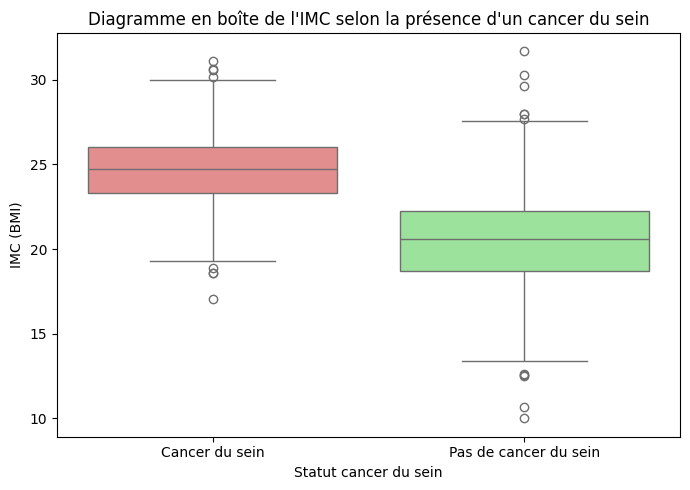

In [34]:
import seaborn as sns

# Boxplot de l'IMC selon la présence d'un cancer du sein
plt.figure(figsize=(7, 5))
sns.boxplot(
    x=bmi_bio['cancer_sein'].map({True: 'Cancer du sein', False: 'Pas de cancer du sein'}),
    y=bmi_bio['transformed_value'],
    palette={'Cancer du sein': 'lightcoral', 'Pas de cancer du sein': 'lightgreen'}
)
plt.xlabel('Statut cancer du sein')
plt.ylabel('IMC (BMI)')
plt.title("Diagramme en boîte de l'IMC selon la présence d'un cancer du sein")
plt.tight_layout()
plt.show()

# Boxplot de l'âge selon la présence d'un cancer du sein
